<a href="https://colab.research.google.com/github/LolitaOnayeva/Detecting-Mental-Health-Conditions-on-Reddit-using-NLP-and-machine-learning-/blob/main/Tune_5K_100D_GLOVE_NN_Mental_Health.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np 
import pandas as pd 
import csv 
import re
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV

from keras.models import Sequential
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.wrappers.scikit_learn import KerasClassifier

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/mental_health_data/full_mental_health_df.csv')

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['post'] = df['post'].apply(clean_text)
df['post'] = df['post'].str.replace('\d+', '')

In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 5000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['post'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 215146 unique tokens.


In [ ]:
X = tokenizer.texts_to_sequences(df['post'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (152966, 250)


In [ ]:
Y = pd.get_dummies(df['subreddit']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (152966, 12)


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(137669, 250) (137669, 12)
(15297, 250) (15297, 12)


In [ ]:
from keras.layers import Input, Embedding, Dense, LSTM,SpatialDropout1D,MaxPooling1D,Conv1D,Flatten,Dropout
from keras.models import Model

In [ ]:
def readGloveFile(gloveFile):
    with open(gloveFile, 'r') as f:
        wordToGlove = {}  
        wordToIndex = {}  
        indexToWord = {}  

        for line in f:
            record = line.strip().split()
            token = record[0] 
            wordToGlove[token] = np.array(record[1:], dtype=np.float64) 
            
        tokens = sorted(wordToGlove.keys())
        for idx, tok in enumerate(tokens):
            kerasIdx = idx + 1  
            wordToIndex[tok] = kerasIdx 
            indexToWord[kerasIdx] = tok 

    return wordToIndex, indexToWord, wordToGlove

In [ ]:
from keras.initializers import Constant

def createPretrainedEmbeddingLayer(wordToGlove, wordToIndex, isTrainable):
    vocabLen = len(wordToIndex) + 1  
    embDim = next(iter(wordToGlove.values())).shape[0]  
   
    embeddingMatrix = np.zeros((vocabLen, embDim))  
    for word, index in wordToIndex.items():
        embeddingMatrix[index, :] = wordToGlove[word] 

    embeddingLayer = Embedding(vocabLen, embDim, embeddings_initializer=Constant(embeddingMatrix), trainable=isTrainable, name='GloVe_Embeddings')
    return embeddingLayer

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip '/content/glove.6B.zip'

--2021-07-26 13:08:48--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-07-26 13:08:48--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-07-26 13:08:48--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
# wordToIndex,indexToWord,wordToGlove=readGloveFile('/content/glove.6B.50d.txt')
wordToIndex,indexToWord,wordToGlove=readGloveFile('/content/glove.6B.100d.txt')
#wordToIndex,indexToWord,wordToGlove=readGloveFile('/content/glove.6B.300d.txt')

# vocabLen = len(wordToIndex) + 1 

EMBED_SIZE = next(iter(wordToGlove.values())).shape[0]
print('Size of Embedding: ',EMBED_SIZE)

embeddingLayer=createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=True)

Size of Embedding:  100


In [ ]:
from keras.layers import Lambda, GlobalAveragePooling1D, Dense, Embedding

In [ ]:
class GlobalAveragePooling1DMasked(GlobalAveragePooling1D):
    def call(self, x, mask=None):
        if mask != None:
            return K.sum(x, axis=1) / K.sum(mask, axis=1)
        else:
            return super().call(x)

#LSTM 100


In [ ]:

target_input = Input((250,), dtype='int32')

target_embedding = embeddingLayer(target_input)

lstm =LSTM(100,return_sequences=False)(target_embedding)

label= Dense(12,activation='softmax')(lstm)

model = Model(inputs=target_input, outputs=label) 
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])


model.summary()




Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 250)]             0         
_________________________________________________________________
GloVe_Embeddings (Embedding) (None, 250, 100)          40000100  
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 12)                1212      
Total params: 40,081,712
Trainable params: 40,081,712
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, Y_train,
                    epochs=10,
                    validation_data=(X_test, Y_test),
                    batch_size=512)

Epoch 1/10
269/269 [==============================] - 566s 2s/step - loss: 1.6029 - accuracy: 0.4590 - val_loss: 0.9617 - val_accuracy: 0.6590
Epoch 2/10
269/269 [==============================] - 540s 2s/step - loss: 0.8217 - accuracy: 0.7148 - val_loss: 0.7075 - val_accuracy: 0.7495
Epoch 3/10
269/269 [==============================] - 543s 2s/step - loss: 0.6392 - accuracy: 0.7709 - val_loss: 0.6110 - val_accuracy: 0.7777
Epoch 4/10
269/269 [==============================] - 544s 2s/step - loss: 0.5649 - accuracy: 0.7940 - val_loss: 0.5944 - val_accuracy: 0.7820
Epoch 5/10
269/269 [==============================] - 543s 2s/step - loss: 0.5201 - accuracy: 0.8078 - val_loss: 0.5581 - val_accuracy: 0.7927
Epoch 6/10
269/269 [==============================] - 541s 2s/step - loss: 0.4998 - accuracy: 0.8142 - val_loss: 0.5524 - val_accuracy: 0.7939
Epoch 7/10
269/269 [==============================] - 547s 2s/step - loss: 0.4606 - accuracy: 0.8255 - val_loss: 0.5545 - val_accuracy: 0.7955

In [ ]:
loss, accuracy = model.evaluate(X_train, Y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, Y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
#plot_history(history)

Training Accuracy: 0.8464
Testing Accuracy:  0.7957


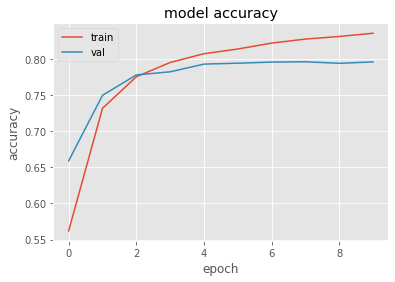

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
rounded_predictions = model.predict(X_test, batch_size=128, verbose=0)
rounded_predictions=np.argmax(rounded_predictions, axis=1)
rounded_predictions[1]
rounded_labels=np.argmax(Y_test, axis=1)
rounded_labels[1]

3

In [ ]:
labels=['anxiety','bipolarreddit','conspiracy','depression','fitness','meditation','parenting',
        'personalfinance','schizophrenia','suicide','teaching','ptsd']
cm = confusion_matrix(rounded_labels, rounded_predictions)
cm

array([[1729,    4,   10,  272,   12,    9,    7,    2,    9,    4,   34,
           1],
       [  18,   87,    3,   45,    0,    1,    1,    0,    5,    8,   10,
           0],
       [  10,    0,  654,   24,    9,    2,   15,    3,    1,    7,   13,
           4],
       [ 246,   16,   22, 4571,   20,    9,   31,    4,   12,   29,  870,
           2],
       [   8,    0,   15,   21, 1669,    1,    7,    1,    0,    2,    2,
           1],
       [  13,    0,    6,   12,    7,  448,    4,    0,    1,    0,    3,
           1],
       [   8,    0,   10,   32,   10,    0,  837,    3,    1,    0,    6,
           4],
       [   1,    0,   11,    4,    1,    0,    7,  124,    0,    0,    0,
           0],
       [  34,    0,    2,   31,    1,    1,    4,    0,  134,    1,   11,
           0],
       [  14,    5,   10,   31,    1,    3,    3,    0,    3,  148,   10,
           0],
       [  42,    1,   10,  828,    5,    2,   12,    3,    6,    8, 1664,
           0],
       [   5,    0,  

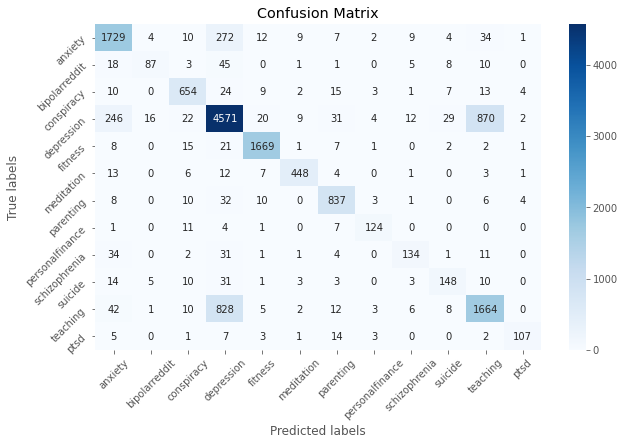

In [ ]:
fig = plt.figure(figsize=(10,6))
ax= plt.subplot()
sns.heatmap(cm, annot=True, cmap='Blues',fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.set_xticklabels(labels=labels,rotation=45); ax.set_yticklabels(labels=labels,rotation=45);

#CNN


In [ ]:

target_input = Input((250,), dtype='int32')

target_embedding = embeddingLayer(target_input)

convolution=Conv1D(64,3,activation='relu')(target_embedding)

global_average=GlobalAveragePooling1DMasked()(convolution)

label= Dense(12,activation='softmax')(global_average)

model2 = Model(inputs=target_input, outputs=label) 
model2.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
model2.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 250)]             0         
_________________________________________________________________
GloVe_Embeddings (Embedding) (None, 250, 100)          40000100  
_________________________________________________________________
conv1d (Conv1D)              (None, 248, 16)           4816      
_________________________________________________________________
global_average_pooling1d_mas (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 12)                204       
Total params: 40,005,120
Trainable params: 40,005,120
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model2.fit(X_train, Y_train,
                    epochs=10,
                    validation_data=(X_test, Y_test),
                    batch_size=512)

Epoch 1/10
269/269 [==============================] - 164s 603ms/step - loss: 2.0203 - accuracy: 0.3554 - val_loss: 1.2985 - val_accuracy: 0.5638
Epoch 2/10
269/269 [==============================] - 161s 600ms/step - loss: 1.1775 - accuracy: 0.6004 - val_loss: 0.9487 - val_accuracy: 0.6776
Epoch 3/10
269/269 [==============================] - 162s 602ms/step - loss: 0.8895 - accuracy: 0.7041 - val_loss: 0.8158 - val_accuracy: 0.7253
Epoch 4/10
269/269 [==============================] - 162s 601ms/step - loss: 0.7632 - accuracy: 0.7411 - val_loss: 0.7505 - val_accuracy: 0.7383
Epoch 5/10
269/269 [==============================] - 162s 601ms/step - loss: 0.7060 - accuracy: 0.7577 - val_loss: 0.7172 - val_accuracy: 0.7463
Epoch 6/10
269/269 [==============================] - 162s 601ms/step - loss: 0.6656 - accuracy: 0.7693 - val_loss: 0.6921 - val_accuracy: 0.7524
Epoch 7/10
269/269 [==============================] - 161s 599ms/step - loss: 0.6331 - accuracy: 0.7788 - val_loss: 0.6754 -

In [ ]:
loss, accuracy = model2.evaluate(X_train, Y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model2.evaluate(X_test, Y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.7999
Testing Accuracy:  0.7742


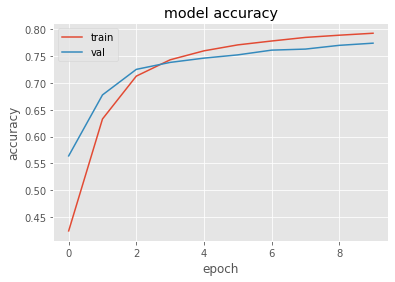

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
rounded_predictions = model.predict(X_test, batch_size=128, verbose=0)
rounded_predictions=np.argmax(rounded_predictions, axis=1)
rounded_predictions[1]
rounded_labels=np.argmax(Y_test, axis=1)
rounded_labels[1]

3

In [ ]:
labels=['anxiety','bipolarreddit','conspiracy','depression','fitness','meditation','parenting',
        'personalfinance','schizophrenia','suicide','teaching','ptsd']
cm = confusion_matrix(rounded_labels, rounded_predictions)
cm

array([[1800,    0,   28,   74,   65,   25,    4,    2,    1,    8,   86,
           0],
       [  35,   13,    9,   49,   21,    4,    0,    0,    1,   24,   22,
           0],
       [  11,    0,  681,    3,   17,    5,    7,    1,    0,    3,   12,
           2],
       [1021,    3,  175, 2274,  227,   29,   25,    4,    7,   68, 1999,
           0],
       [   5,    0,   12,    5, 1700,    1,    2,    0,    0,    0,    2,
           0],
       [  32,    0,    9,    2,   21,  424,    1,    0,    0,    3,    3,
           0],
       [  23,    0,   31,    8,  107,    3,  708,    6,    0,    1,   21,
           3],
       [   3,    0,   22,    4,    4,    0,    1,  113,    0,    0,    1,
           0],
       [  97,    2,    9,   12,   12,    2,    4,    0,   47,    7,   27,
           0],
       [  34,    0,   19,   14,    4,   10,    3,    0,    0,  119,   25,
           0],
       [ 168,    0,   78,  294,   34,    4,    6,    1,    1,   13, 1982,
           0],
       [   6,    0,  

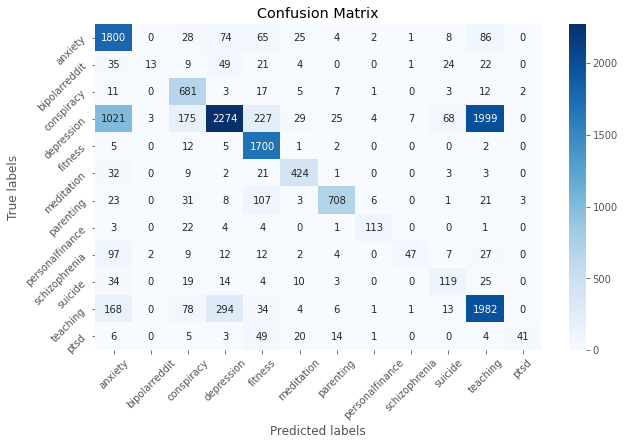

In [ ]:
fig = plt.figure(figsize=(10,6))
ax= plt.subplot()
sns.heatmap(cm, annot=True, cmap='Blues',fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.set_xticklabels(labels=labels,rotation=45); ax.set_yticklabels(labels=labels,rotation=45);

#LSTM+CNN


In [ ]:
target_input = Input((250,), dtype='int32')

target_embedding = embeddingLayer(target_input)

convolution=Conv1D(16,3,activation='relu')(target_embedding)

#global_average=GlobalAveragePooling1DMasked()(convolution)

lstm =LSTM(100,return_sequences=False)(convolution)

label= Dense(12,activation='softmax')(lstm)

model3 = Model(inputs=target_input, outputs=label) 
model3.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
model3.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 250)]             0         
_________________________________________________________________
GloVe_Embeddings (Embedding) (None, 250, 100)          40000100  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 248, 16)           4816      
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               46800     
_________________________________________________________________
dense_2 (Dense)              (None, 12)                1212      
Total params: 40,052,928
Trainable params: 40,052,928
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model3.fit(X_train, Y_train,
                    epochs=10,
                    validation_data=(X_test, Y_test),
                    batch_size=512)

Epoch 1/10
269/269 [==============================] - 498s 2s/step - loss: 1.2427 - accuracy: 0.5912 - val_loss: 0.6735 - val_accuracy: 0.7637
Epoch 2/10
269/269 [==============================] - 493s 2s/step - loss: 0.5925 - accuracy: 0.7892 - val_loss: 0.6160 - val_accuracy: 0.7730
Epoch 3/10
269/269 [==============================] - 488s 2s/step - loss: 0.5305 - accuracy: 0.8049 - val_loss: 0.5662 - val_accuracy: 0.7932
Epoch 4/10
269/269 [==============================] - 488s 2s/step - loss: 0.4873 - accuracy: 0.8184 - val_loss: 0.5544 - val_accuracy: 0.7964
Epoch 5/10
269/269 [==============================] - 490s 2s/step - loss: 0.4779 - accuracy: 0.8197 - val_loss: 0.5644 - val_accuracy: 0.7921
Epoch 6/10
269/269 [==============================] - 490s 2s/step - loss: 0.4592 - accuracy: 0.8252 - val_loss: 0.5515 - val_accuracy: 0.7947
Epoch 7/10
269/269 [==============================] - 489s 2s/step - loss: 0.4476 - accuracy: 0.8297 - val_loss: 0.5502 - val_accuracy: 0.7961

In [ ]:
loss, accuracy = model3.evaluate(X_train, Y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model3.evaluate(X_test, Y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.8385
Testing Accuracy:  0.7921


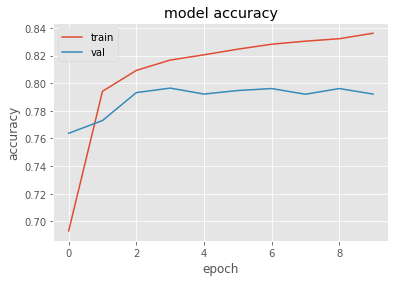

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
rounded_predictions3 = model3.predict(X_test, batch_size=128, verbose=0)
rounded_predictions3=np.argmax(rounded_predictions3, axis=1)
rounded_predictions3[1]
rounded_labels3=np.argmax(Y_test, axis=1)
rounded_labels3[1]

3

In [ ]:
labels=['anxiety','bipolarreddit','conspiracy','depression','fitness','meditation','parenting',
        'personalfinance','schizophrenia','suicide','teaching','ptsd']
cm3 = confusion_matrix(rounded_labels3, rounded_predictions3)
cm3

array([[1681,    7,    8,  301,   10,   12,    6,    1,   10,   11,   43,
           3],
       [  16,   88,    1,   43,    0,    1,    0,    0,    1,    6,   16,
           6],
       [   5,    1,  630,   37,    9,    2,    8,   15,    0,   10,   16,
           9],
       [ 165,   23,   16, 4488,   16,    5,   21,    5,   14,   37, 1037,
           5],
       [   7,    1,   11,   31, 1658,    0,    6,    4,    0,    0,    3,
           6],
       [  10,    0,    6,   20,    3,  446,    0,    0,    1,    3,    3,
           3],
       [   9,    0,   18,   37,    7,    0,  817,    4,    0,    5,    9,
           5],
       [   1,    0,    4,    4,    0,    0,    5,  134,    0,    0,    0,
           0],
       [  28,    2,    2,   25,    2,    0,    3,    0,  133,    6,   18,
           0],
       [  11,    8,    5,   30,    0,    0,    3,    1,    2,  155,   12,
           1],
       [  28,    2,    7,  753,    1,    2,    4,    5,    3,    9, 1767,
           0],
       [   3,    0,  

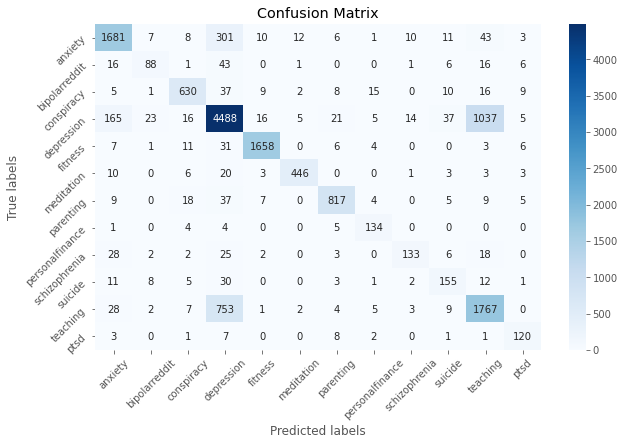

In [ ]:
fig = plt.figure(figsize=(10,6))
ax= plt.subplot()
sns.heatmap(cm3, annot=True, cmap='Blues',fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.set_xticklabels(labels=labels,rotation=45); ax.set_yticklabels(labels=labels,rotation=45);

#CNN+LSTM+64

In [ ]:
target_input = Input((250,), dtype='int32')

target_embedding = embeddingLayer(target_input)

convolution=Conv1D(64,3,activation='relu')(target_embedding)

#global_average=GlobalAveragePooling1DMasked()(convolution)

lstm =LSTM(100,return_sequences=False)(convolution)

label= Dense(12,activation='softmax')(lstm)

model4 = Model(inputs=target_input, outputs=label) 
model4.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
model4.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 250)]             0         
_________________________________________________________________
GloVe_Embeddings (Embedding) (None, 250, 100)          40000100  
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 248, 64)           19264     
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               66000     
_________________________________________________________________
dense_3 (Dense)              (None, 12)                1212      
Total params: 40,086,576
Trainable params: 40,086,576
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model4.fit(X_train, Y_train,
                    epochs=10,
                    validation_data=(X_test, Y_test),
                    batch_size=512)

Epoch 1/10
269/269 [==============================] - 602s 2s/step - loss: 1.1031 - accuracy: 0.6287 - val_loss: 0.6052 - val_accuracy: 0.7815
Epoch 2/10
269/269 [==============================] - 628s 2s/step - loss: 0.5053 - accuracy: 0.8126 - val_loss: 0.5651 - val_accuracy: 0.7952
Epoch 3/10
269/269 [==============================] - 619s 2s/step - loss: 0.4651 - accuracy: 0.8240 - val_loss: 0.5535 - val_accuracy: 0.7964
Epoch 4/10
269/269 [==============================] - 624s 2s/step - loss: 0.4406 - accuracy: 0.8311 - val_loss: 0.5522 - val_accuracy: 0.7947
Epoch 5/10
269/269 [==============================] - 617s 2s/step - loss: 0.4262 - accuracy: 0.8359 - val_loss: 0.5507 - val_accuracy: 0.7970
Epoch 6/10
269/269 [==============================] - 610s 2s/step - loss: 0.4159 - accuracy: 0.8387 - val_loss: 0.5631 - val_accuracy: 0.7929
Epoch 7/10
269/269 [==============================] - 615s 2s/step - loss: 0.4062 - accuracy: 0.8417 - val_loss: 0.5588 - val_accuracy: 0.7957

In [ ]:
loss, accuracy = model4.evaluate(X_train, Y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model4.evaluate(X_test, Y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.8573
Testing Accuracy:  0.7929


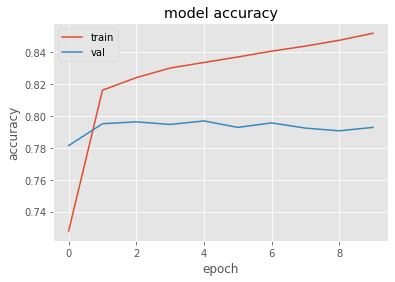

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
rounded_predictions4 = model4.predict(X_test, batch_size=128, verbose=0)
rounded_predictions4=np.argmax(rounded_predictions4, axis=1)
rounded_predictions4[1]
rounded_labels4=np.argmax(Y_test, axis=1)
rounded_labels4[1]

3

In [ ]:
labels=['anxiety','bipolarreddit','conspiracy','depression','fitness','meditation','parenting',
        'personalfinance','schizophrenia','suicide','teaching','ptsd']
cm4 = confusion_matrix(rounded_labels4, rounded_predictions3)
cm4

array([[1681,    7,    8,  301,   10,   12,    6,    1,   10,   11,   43,
           3],
       [  16,   88,    1,   43,    0,    1,    0,    0,    1,    6,   16,
           6],
       [   5,    1,  630,   37,    9,    2,    8,   15,    0,   10,   16,
           9],
       [ 165,   23,   16, 4488,   16,    5,   21,    5,   14,   37, 1037,
           5],
       [   7,    1,   11,   31, 1658,    0,    6,    4,    0,    0,    3,
           6],
       [  10,    0,    6,   20,    3,  446,    0,    0,    1,    3,    3,
           3],
       [   9,    0,   18,   37,    7,    0,  817,    4,    0,    5,    9,
           5],
       [   1,    0,    4,    4,    0,    0,    5,  134,    0,    0,    0,
           0],
       [  28,    2,    2,   25,    2,    0,    3,    0,  133,    6,   18,
           0],
       [  11,    8,    5,   30,    0,    0,    3,    1,    2,  155,   12,
           1],
       [  28,    2,    7,  753,    1,    2,    4,    5,    3,    9, 1767,
           0],
       [   3,    0,  

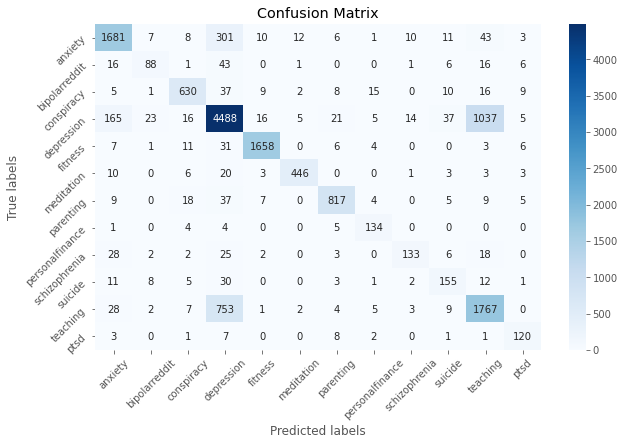

In [ ]:
fig = plt.figure(figsize=(10,6))
ax= plt.subplot()
sns.heatmap(cm4, annot=True, cmap='Blues',fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.set_xticklabels(labels=labels,rotation=45); ax.set_yticklabels(labels=labels,rotation=45);